In [24]:
!pip install scikit-image

     |████████████████████████████████| 30.2 MB 5.5 MB/s eta 0:00:01
     |████████████████████████████████| 3.3 MB 26.4 MB/s eta 0:00:01
     |████████████████████████████████| 4.4 MB 47.3 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 26.1 MB/s eta 0:00:01
  Attempting uninstall: decorator
    Found existing installation: decorator 5.0.7
    Uninstalling decorator-5.0.7:
      Successfully uninstalled decorator-5.0.7


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import glob

from tqdm import tqdm

import plotly.graph_objects as go

from model import utils

import json
import os
import rasterio
from rasterio.mask import mask as rasterio_mask
import cv2
import seaborn as sns
from skimage.measure import regionprops_table

In [3]:
train_df = pd.read_csv(os.path.join(utils.TRAIN_PATH))
train_df.head()

,id,encoding
0,2f6ecfcdf,296084587 4 296115835 6 296115859 14 296147109...
1,8242609fa,96909968 56 96941265 60 96972563 64 97003861 6...
2,aaa6a05cc,30989109 59 31007591 64 31026074 68 31044556 7...
3,cb2d976f4,78144363 5 78179297 15 78214231 25 78249165 35...
4,b9a3865fc,61271840 4 61303134 13 61334428 22 61365722 30...


In [4]:
def verify_read(file_list):
    for file_name in file_list:
        with rasterio.open(file_name) as image:
            print(f'path = {file_name},\n'
                  f'shape = {image.shape},\n'
                  f'meta = {image.meta}\n')

In [5]:
file_list = glob.glob(f'{utils.TRAIN_DIR}/*.tiff')
verify_read(file_list)

path = /data/kaggle/hubmap/train/b9a3865fc.tiff,
shape = (31295, 40429),
meta = {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 40429, 'height': 31295, 'count': 3, 'crs': None, 'transform': Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0)}

path = /data/kaggle/hubmap/train/b2dc8411c.tiff,
shape = (14844, 31262),
meta = {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 31262, 'height': 14844, 'count': 3, 'crs': None, 'transform': Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0)}

path = /data/kaggle/hubmap/train/1e2425f28.tiff,
shape = (26780, 32220),
meta = {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 32220, 'height': 26780, 'count': 1, 'crs': None, 'transform': Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0)}

path = /data/kaggle/hubmap/train/e79de561c.tiff,
shape = (16180, 27020),
meta = {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 27020, 'height': 16180, 'count': 3, 'crs': None, 'transform': Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0

/home/nishaq/Documents/kaggle/.kaggle/lib/python3.8/site-packages/rasterio/__init__.py:207: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [8]:
def resize(image, s=1, shape=None):
    image_t = image.transpose(1,2,0)
    if shape is not None:
        new_image = np.zeros((shape[0], shape[1], 3)).astype(np.uint8)
    else:
        new_image = np.zeros((image_t.shape[0] // s, image_t.shape[1] // s, 3)).astype(np.uint8)
    for i in range(3):
        temp = new_image[:,:,i]
        new_image[:,:,i] = cv2.resize(temp, (new_image.shape[1], new_image.shape[0]))
    new_image = new_image.transpose(2,0,1)
    return new_image

In [9]:
ids = list(train_df['id'])
surface_summary = dict()
r = 4

for id_ in tqdm(ids):
    tot_annotated = 0
    tot_usefull_surface = 0
    
    path_tiff = f'{utils.TRAIN_DIR}/{id_}.tiff'
    path_json1 = f'{utils.TRAIN_DIR}/{id_}-anatomical-structure.json'
    path_json2 = f'{utils.TRAIN_DIR}/{id_}.json'
    
    ########LOAD ANNOTATIONS#####
    with open(path_json1, 'r') as f:
        aois1 = json.load(f)
    
    with open(path_json2, 'r') as f:
        aois2 = json.load(f)
    
    polys1 = [elmt['geometry'] for elmt in aois1]
    polys2 = [elmt['geometry'] for elmt in aois2]
    
    #######OPEN RASTER AND RESIZE##########
    with rasterio.open(path_tiff) as raster:
        crs = raster.crs
        transform = raster.transform
        image = raster.read()
    
    # Resize
    image = resize(image, r)
    shape_ = image[0].shape
    
    #This array is used to remove pixels already visited, in case of overlapping of annotations
    visited = np.ones(shape_)
    
    #Readjust affine transformation
    transform = transform * transform.scale(r, r)
    
    # Save resized
    with rasterio.open(f'{id_}.tif', 'w', driver='GTiff',
                       height=image.shape[1],
                       width=image.shape[2],
                       count=image.shape[0],
                       dtype=image.dtype,
                       crs=crs,
                       transform=transform) as fp:
        fp.write(img)
    
    with rasterio.open(f'{id_}.tif') as raster
        #Generate masks
        for poly in polys1:
            mask1 = rasterio_mask(raster, [poly])[0][0]
            mask1[mask1 > 0] = 1
            mask2 = rasterio_mask(raster, polys2)[0][0]
            mask2[mask2 > 0]= 1
            
            cg = (mask1 * mask2 * visited).sum()
            tot_annotated += (mask1 * visited).sum()
            
            if cg.sum() > 0:  # if there is glomeruli in the annotation
                tot_usefull_surface += (mask1 * visited).sum()
            
            visited = visited - mask1
            visited[visited < 0] = 0
    
    tot_surface = shape_[0] * shape_[1]
    tot_glomeruli = mask2.sum()
    
    surface_summary[id_] = {}
    surface_summary[id_]['tot_surface'] = tot_surface
    surface_summary[id_]['tot_glomeruli'] = tot_glomeruli
    surface_summary[id_]['tot_annotated'] = tot_annotated
    surface_summary[id_]['tot_usefull_surface'] = tot_usefull_surface

100%|██████████| 15/15 [06:08<00:00, 24.59s/it]


In [10]:
df_surface = pd.DataFrame(surface_summary).T

df_surface['glomeruli_density_tot'] = df_surface.tot_glomeruli / df_surface.tot_surface
df_surface['glomeruli_density_annotated'] = df_surface.tot_glomeruli / df_surface.tot_annotated
df_surface['glomeruli_density_usefull'] = df_surface.tot_glomeruli / df_surface.tot_usefull_surface
df_surface['tot_annotated_ratio'] = df_surface.tot_annotated / df_surface.tot_surface
df_surface['tot_usefull_ratio'] = df_surface.tot_usefull_surface / df_surface.tot_surface

df_surface = np.round(df_surface, 3)

df_surface = df_surface.sort_values('glomeruli_density_usefull', ascending=False)
df_surface

,tot_surface,tot_glomeruli,tot_annotated,tot_usefull_surface,glomeruli_density_tot,glomeruli_density_annotated,glomeruli_density_usefull,tot_annotated_ratio,tot_usefull_ratio
2f6ecfcdf,50416912.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0
8242609fa,86189184.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0
aaa6a05cc,15032113.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0
cb2d976f4,108200445.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0
b9a3865fc,79067061.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0
b2dc8411c,29001465.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0
0486052bb,56299364.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0
e79de561c,27323975.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0
095bf7a1f,93015000.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0
54f2eec69,42311600.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0


In [14]:
glomeruli_metadata = dict()
for id_ in ids:
    glomeruli_metadata[id_] = {
        'width': list(),
        'height': list(),
        'surface': list()
    }
    path_tiff = f'{utils.TRAIN_DIR}/{id_}.tiff'
    path_json2 = f'{utils.TRAIN_DIR}/{id_}.json'
    
    with open(path_json2, 'r') as f:
        aois2 = json.load(f)
    
    polys2 = [elmt['geometry'] for elmt in aois2]
    with rasterio.open(path_tiff) as raster:
        for poly in tqdm(polys2):
            m = rasterio_mask(raster, [poly], crop = True)[0][0]
            
            glomeruli_metadata[id_]['width'].append(m.shape[1])
            glomeruli_metadata[id_]['height'].append(m.shape[0])

            m[m > 0] = 1
            glomeruli_metadata[id_]['surface'].append(np.sum(m))

/home/nishaq/Documents/kaggle/.kaggle/lib/python3.8/site-packages/rasterio/__init__.py:207: NotGeoreferencedWarning:

Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.

100%|██████████| 178/178 [00:01<00:00, 138.38it/s]


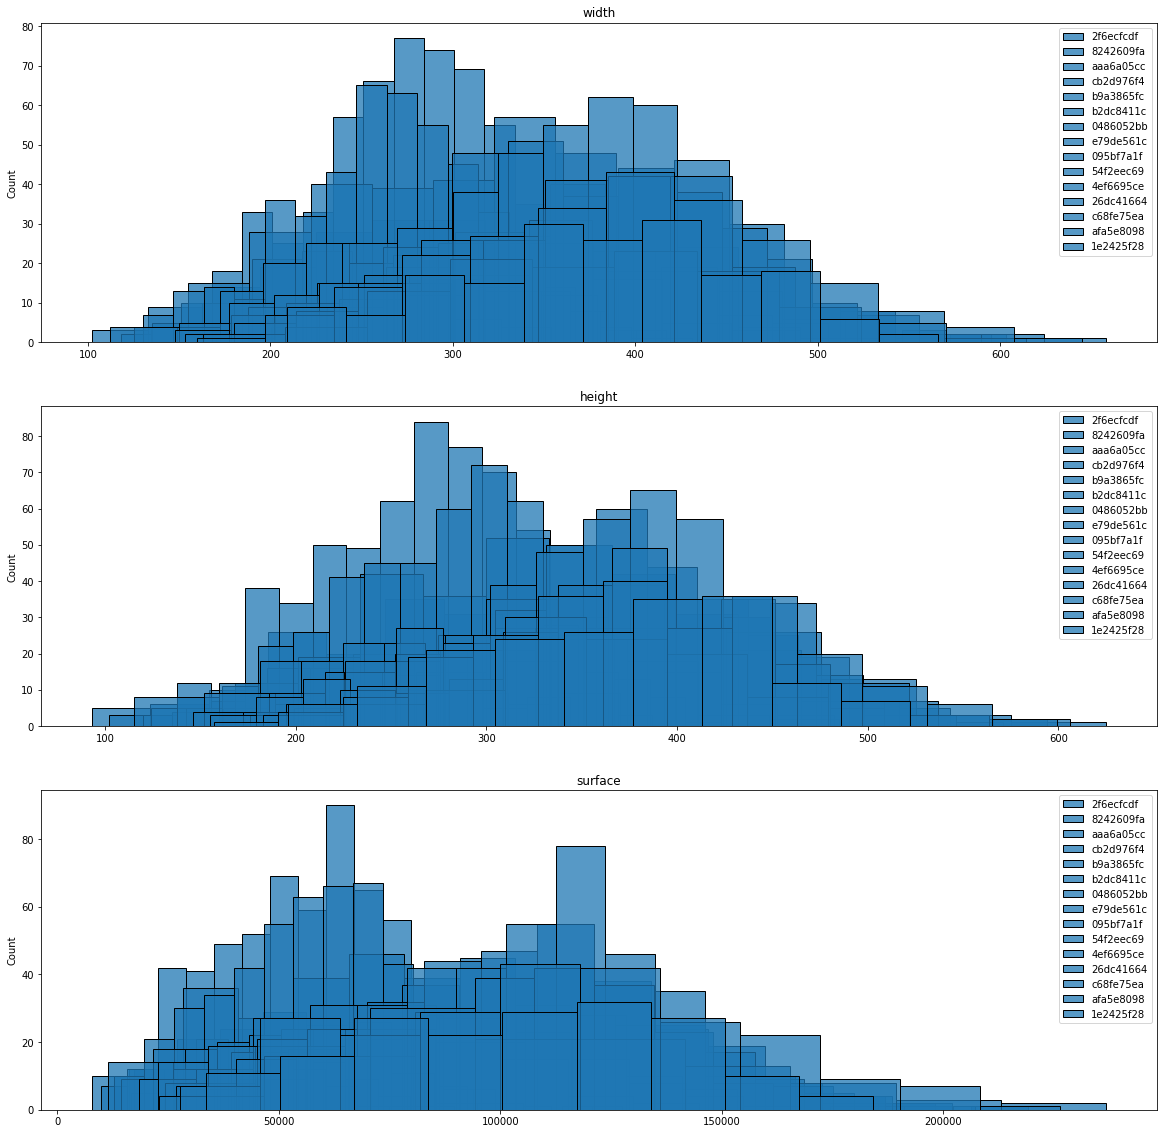

In [17]:
plt.figure(figsize=(20, 20))
plt.subplot(3, 1, 1)
plt.title('width')

for k, v in glomeruli_metadata.items():
    sns.histplot(v['width'], label=k)

plt.legend()
plt.subplot(3, 1, 2)
plt.title('height')

for k, v in glomeruli_metadata.items():
    sns.histplot(v['height'], label=k)

plt.legend()
plt.subplot(3, 1, 3)
plt.title('surface')

for k, v in glomeruli_metadata.items():
    sns.histplot(v['surface'], label=k)

plt.legend()

In [18]:
heights = [v['height'] for v in glomeruli_metadata.values()]
widths = [v['width'] for v in glomeruli_metadata.values()]
areas = [v['surface'] for v in glomeruli_metadata.values()]

In [19]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=widths,
    y=heights,
    opacity=0.5,
    mode='markers',
))
fig.update_layout(template='presentation', title='Space taken by the glomeruli')
fig.update_xaxes(title='width')
fig.update_yaxes(title='height')
fig.show()

In [26]:
glomeruli_metadata = dict()
for id_ in tqdm(ids):
    glomeruli_metadata[id_] = {
        'orientation': list(),
        'major_axis_length': list(),
        'minor_axis_length': list(),
    }
    path_tiff = f'{utils.TRAIN_DIR}/{id_}.tiff'
    path_json2 = f'{utils.TRAIN_DIR}/{id_}.json'

    with open(path_json2, 'r') as f:
        aois2 = json.load(f)

    polys2 = [elmt['geometry'] for elmt in aois2]
    with rasterio.open(path_tiff) as raster:
        for poly in polys2:
            m = rasterio_mask(raster, [poly], crop=True)[0][0]
            m[m > 0] = 1
            if m.sum() > 0:
                props = regionprops_table(m, properties=('orientation',
                                                         'major_axis_length',
                                                         'minor_axis_length'))

                glomeruli_metadata[id_]['orientation'].append(props['orientation'])
                glomeruli_metadata[id_]['major_axis_length'].append(props['major_axis_length'])
                glomeruli_metadata[id_]['minor_axis_length'].append(props['minor_axis_length'])

  0%|          | 0/15 [00:00<?, ?it/s]/home/nishaq/Documents/kaggle/.kaggle/lib/python3.8/site-packages/rasterio/__init__.py:207: NotGeoreferencedWarning:

Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.

100%|██████████| 15/15 [02:19<00:00,  9.29s/it]


In [ ]:
plt.figure(figsize=(20, 20))
plt.subplot(3, 1, 1)
plt.title('orientation')

for k, v in glomeruli_metadata.items():
    sns.histplot(np.abs(v['orientation']), label=k)

plt.legend()
plt.subplot(3, 1, 2)
plt.title('major_axis_length')

for k, v in glomeruli_metadata.items():
    sns.histplot(v['major_axis_length'], label=k)

plt.legend()
plt.subplot(3, 1, 3)
plt.title('minor_axis_length')

for k, v in glomeruli_metadata.items():
    sns.histplot(v['minor_axis_length'], label=k)

plt.legend()
plt.show()